# Hierarchical Clustering

In [5]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=3)
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

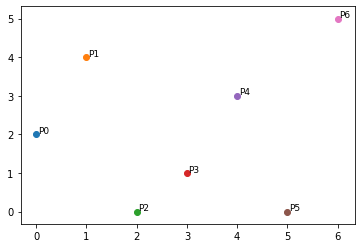

In [7]:
x2 = np.array([2, 4, 0, 1, 3, 0, 5])
x1 = np.array(list(range(len(x2))))
X = np.vstack((x1,x2)).T

labels = ['P{}'.format(i) for i in x1]

for i,(x1i,x2i) in enumerate(zip(x1,x2)):
    plt.scatter(x1i, x2i)
    plt.text(x1i+.03, x2i+.03, labels[i], fontsize=9)
plt.show()

#### Using Euclidean Distances

In [8]:
Z_ = linkage(pdist(X), metric='euclidean', method='average')
pd.DataFrame(Z_, columns=['P1','P2','Distance','Points in Cluster'])

,P1,P2,Distance,Points in Cluster
0,2.00,3.00,1.41,2.00
1,0.00,1.00,2.24,2.00
2,5.00,7.00,2.62,3.00
3,4.00,6.00,2.83,2.00
4,8.00,9.00,4.13,5.00
5,10.00,11.00,4.46,7.00


#### Using Cosine Distances

In [9]:
distances = pdist(X,metric='cosine') # Returns the upper half matrix of the cosine distances matrix  
Z = linkage(y=distances, method='ward')
pd.DataFrame(Z, columns=['P1','P2','Distance','Points in Cluster'])

,P1,P2,Distance,Points in Cluster
0,2.00,5.00,0.00,2.00
1,4.00,6.00,0.00,2.00
2,0.00,1.00,0.03,2.00
3,3.00,7.00,0.06,3.00
4,8.00,10.00,0.28,5.00
5,9.00,11.00,1.09,7.00


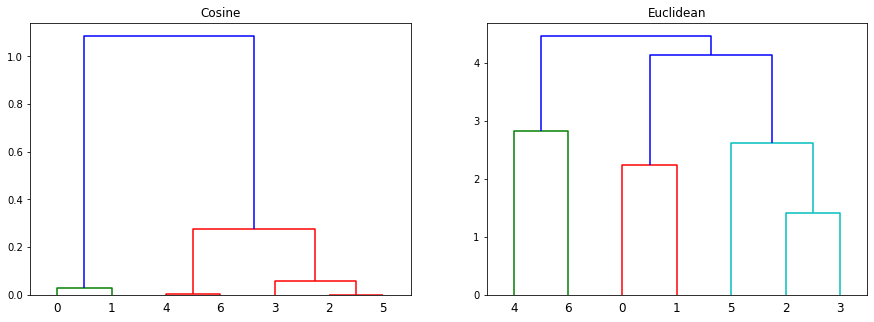

In [10]:
_, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Cosine')
ax2.set_title('Euclidean')
_ = dendrogram(Z, ax=ax1)
_ = dendrogram(Z_, ax=ax2)

In [11]:
cluster_dict = defaultdict(list)
clusters = fcluster(Z_, t=7, criterion='maxclust')

for i, c in enumerate(clusters):
    cluster_dict[c].append(i)
print(cluster_dict)

defaultdict(<class 'list'>, {3: [0, 1], 4: [2, 3], 1: [4], 5: [5], 2: [6]})


### Retrieve Cluster ID of each document

#### Assuming we know k --> Alternatives using distances etc

In [12]:
def same_dicts(d1,d2):
    return all([v1 == v2 for v1,v2 in zip(d1.values(), d2.values())])

In [13]:
def retrieve_doc_idx_by_level(cluster_idx, idx):
    ''' Return the indexes of the documents that match the cluster id '''
    doc_ids = np.array(list(range(len(cluster_idx))))
    mask = cluster_idx==idx
    return [c for c,i in zip(doc_ids,mask) if i]

In [14]:
def retrieve_hca_info(Z, criterion='maxclust', min_clusters=2, max_clusters=len(Z)//2+1):
    ''' Retrive the documents that belong to each cluster 
    for every merge done during the HCA process ''' 
    cluster_dict = defaultdict(lambda: defaultdict(list))
    for level in range(max_clusters, min_clusters-1, -1):
        cluster_idx = fcluster(Z, level, criterion=criterion)
        for c in range(1,1+level):
            cluster_dict[level][c].append(retrieve_doc_idx_by_level(cluster_idx,c))
    return cluster_dict

In [17]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 5
CRITERION = 'maxclust'
cluster_dict = retrieve_hca_info(Z_, CRITERION, MIN_CLUSTERS, MAX_CLUSTERS)

In [18]:
cluster_dict

defaultdict(<function __main__.retrieve_hca_info.<locals>.<lambda>()>,
            {5: defaultdict(list,
                         {1: [[4]],
                          2: [[6]],
                          3: [[0, 1]],
                          4: [[2, 3]],
                          5: [[5]]}),
             4: defaultdict(list,
                         {1: [[4]], 2: [[6]], 3: [[0, 1]], 4: [[2, 3, 5]]}),
             3: defaultdict(list, {1: [[4, 6]], 2: [[0, 1]], 3: [[2, 3, 5]]}),
             2: defaultdict(list, {1: [[4, 6]], 2: [[0, 1, 2, 3, 5]]})})

## Pipeline until TFIDF

In [13]:
import os
import pickle
from pprint import pprint
from os.path import join as JP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

catalog = Catalog()
catalog = load_catalog(path=paths['catalog'], name='spacy_pipeline_on_US_corpus')
catalog.documents = catalog.documents[:6]
print('Total documents = ', len(catalog.documents))
corpus = catalog.collect_corpus(attr='processed_text', form=list)

EMBED_SIZE = 10000        
NUM_CLUSTERS = 4
WORDS_PER_CLUSTER = 50

vectorizer = TfidfVectorizer(
    min_df=.1,
    max_df=.7,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
print(tfidf.representation.shape)
tfidf.representation.head()

Total documents =  6
(6, 10000)


,0000,0021,0023,0069,0076,14,14 composition,14 composition liquid,15,2h,...,yield methyl,yield methyl trimethylcyclohexylcarbamic,yield product,yield product obtain,yield reaction,yield reaction temperature,yield structural,yield structural assignment,zeolite,zinc
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,...,0.00,0.00,0.02,0.01,0.00,0.00,0.05,0.05,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [14]:
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.figure_factory as ff

## Hierarchical Clustering

### Similarity Matrix

In [15]:
from scripts.algorithms.clustering import (
    hca_document_clustering, plot_dendogram_from_linkage_matrix)

In [16]:
Z = hca_document_clustering(tfidf, method='ward', distance_metric='cosine')
Z

[INFO]: Computing Distance Matrix using cosine distance
[INFO]: Performing Hierarchical Clustering using ward linkage


array([[0.   , 2.   , 0.903, 2.   ],
       [1.   , 4.   , 0.919, 2.   ],
       [5.   , 6.   , 0.962, 3.   ],
       [3.   , 7.   , 0.971, 3.   ],
       [8.   , 9.   , 1.036, 6.   ]])

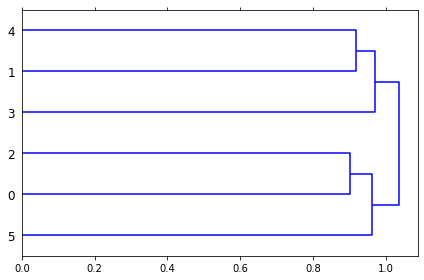

In [17]:
plot_dendogram_from_linkage_matrix(
    Z, truncate_mode='lastp', p=6, 
    show_leaf_counts=True, leaf_rotation=0.)

In [18]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 6
CRITERION = 'maxclust'
cluster_dict = retrieve_hca_info(Z, CRITERION, MIN_CLUSTERS, MAX_CLUSTERS)

In [19]:
cluster_dict

defaultdict(<function __main__.retrieve_hca_info.<locals>.<lambda>()>,
            {2: defaultdict(list, {0: [[0, 2, 5]], 1: [[1, 3, 4]]}),
             3: defaultdict(list, {0: [[0, 2, 5]], 1: [[1, 4]], 2: [[3]]}),
             4: defaultdict(list,
                         {0: [[0, 2]], 1: [[5]], 2: [[1, 4]], 3: [[3]]}),
             5: defaultdict(list,
                         {0: [[0, 2]],
                          1: [[5]],
                          2: [[1, 4]],
                          3: [[3]],
                          4: [[]]}),
             6: defaultdict(list,
                         {0: [[0, 2]],
                          1: [[5]],
                          2: [[1, 4]],
                          3: [[3]],
                          4: [[]],
                          5: [[]]})})